<center><h1>QBUS6860 - Visual Data Analytics</h1></center>

# Tutorial 6 - Time Series

## Learning objectives and tasks:

1. Preparing a time series dataframe using data munging functions covered in Lecture 2;
2. Manipulating dates - rolling up from detailed (for example, hourly) timestamps to broader (for example, daily) intervals;
3. Calculation of variables over time - sum or average of time series variable over time.

## Task 1: Preparing a time series dataframe

In [2]:
import numpy as np
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

df=pd.read_csv('electricity.csv') 
df

,REGIONID,INTERVAL_DATETIME,OPERATIONAL_DEMAND
0,NSW1,2022/09/18 00:00:00,7568
1,QLD1,2022/09/18 00:00:00,5575
2,SA1,2022/09/18 00:00:00,1578
3,TAS1,2022/09/18 00:00:00,1071
4,VIC1,2022/09/18 00:00:00,5349
...,...,...,...
1675,NSW1,2022/09/24 23:30:00,7561
1676,QLD1,2022/09/24 23:30:00,5694
1677,SA1,2022/09/24 23:30:00,1428
1678,TAS1,2022/09/24 23:30:00,1184


> Ask yourself: 
> 1. What do you notice about this dataset? 
> 2. Is it readily suitable for plotting time series charts?

In [3]:
# Inspect dataframe variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   REGIONID            1680 non-null   object
 1   INTERVAL_DATETIME   1680 non-null   object
 2   OPERATIONAL_DEMAND  1680 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 39.5+ KB


In [4]:
# Rename variables in dataframe
df.rename(columns = {'REGIONID':'region', 
                     'INTERVAL_DATETIME':'datetime', 
                     'OPERATIONAL_DEMAND':'demand'}, 
          inplace = True)
df.head(10)

,region,datetime,demand
0,NSW1,2022/09/18 00:00:00,7568
1,QLD1,2022/09/18 00:00:00,5575
2,SA1,2022/09/18 00:00:00,1578
3,TAS1,2022/09/18 00:00:00,1071
4,VIC1,2022/09/18 00:00:00,5349
5,NSW1,2022/09/18 00:30:00,7356
6,QLD1,2022/09/18 00:30:00,5399
7,SA1,2022/09/18 00:30:00,1551
8,TAS1,2022/09/18 00:30:00,1058
9,VIC1,2022/09/18 00:30:00,5172


To create line plots, the dataframe needs to be shaped in a way where successive rows in a single column represent a single series (a single variable across time).

Currently <code>df</code> is not suitable because every row represents a different region. 

There are several ways to create a new dataframe that is suitable for line plots.

In [5]:
# Option 1 (for illustration only for now): pivoting entire dataframe into separate time series first,
# then select two columns, 'datetime' and another region to form a new dataframe for line plots
# refer to data munging functions in Lecture 2. we will apply this transformation in Task 3.2
df.\
    pivot(columns='region', index='datetime', values='demand').\
    reset_index().\
    rename_axis(None, axis=1).\
    rename(columns={'NSW1':'nsw', 'QLD1':'qld', 'SA1':'sa', 'TAS1':'tas', 'VIC1':'vic'})

,datetime,nsw,qld,sa,tas,vic
0,2022/09/18 00:00:00,7568,5575,1578,1071,5349
1,2022/09/18 00:30:00,7356,5399,1551,1058,5172
2,2022/09/18 01:00:00,7167,5269,1551,1042,4968
3,2022/09/18 01:30:00,6986,5187,1503,1034,4831
4,2022/09/18 02:00:00,6774,5106,1462,1028,4623
...,...,...,...,...,...,...
331,2022/09/24 21:30:00,7939,6173,1624,1308,5450
332,2022/09/24 22:00:00,7824,6034,1594,1278,5326
333,2022/09/24 22:30:00,7798,5911,1553,1248,5220
334,2022/09/24 23:00:00,7667,5764,1478,1212,5083


In [6]:
# Option 2: Filter on 'region' to focus on NSW only
# this results in a dataframe with 3 variables. 'region' is redundant and not necessary for line plots
df = df[df['region']=='NSW1']
df.head(10)

,region,datetime,demand
0,NSW1,2022/09/18 00:00:00,7568
5,NSW1,2022/09/18 00:30:00,7356
10,NSW1,2022/09/18 01:00:00,7167
15,NSW1,2022/09/18 01:30:00,6986
20,NSW1,2022/09/18 02:00:00,6774
25,NSW1,2022/09/18 02:30:00,6571
30,NSW1,2022/09/18 03:00:00,6420
35,NSW1,2022/09/18 03:30:00,6272
40,NSW1,2022/09/18 04:00:00,6232
45,NSW1,2022/09/18 04:30:00,6252


We can quickly use <code>seaborn</code>'s <code>lineplot</code> to draw time series. Let us try it first. Clearly we will use <code>datetime</code> for the  x-axis and <code>demand</code> for the y-axis. 

<Axes: xlabel='datetime', ylabel='demand'>

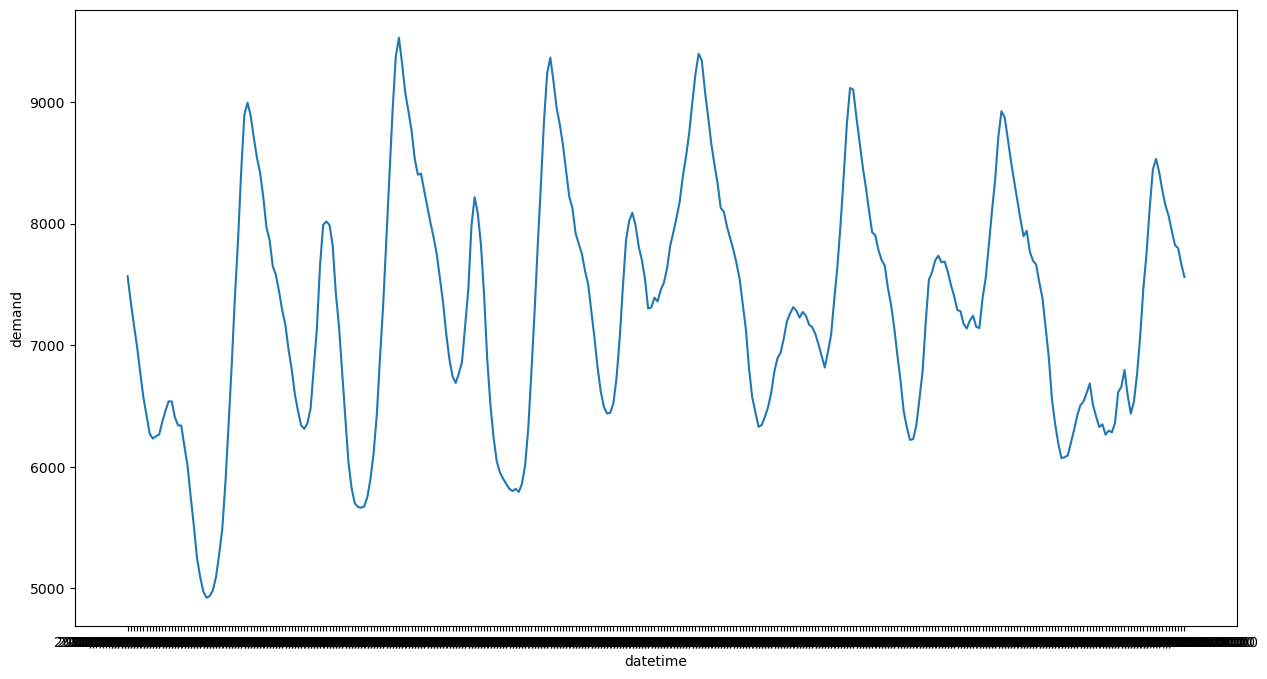

In [7]:
plt.figure(figsize = (15, 8))
sns.lineplot(x = 'datetime', y = 'demand', data = df)

> Ask yourself: 
> 1. What do you notice in the plot above? 
> 2. How would you change the plot?

## Task 2: Dealing with datetime data type to explore time series characteristics

From the above plot, we have seen that it is hard to see the details of date. All the xticks labels are cluttered because the date string are too long and too many.  How could we improve this?

Basically <code>seaborn</code> has clever ways to selectly show x-axis tick labels. As the date information are text <code>string</code>, it is hard for <code>seaborn</code> to decide which labels (dates) should be drawn which should be discarded.  When x-axis is presented as numerical values, <code>seaborn</code> knows how to deal with. 

Clearly we know the information in <code>datetime</code> is time (dates), so we shall let <code>seaborn</code> know of this. <code>seaborn</code> knows how to deal with time.  This comes to the following code to convert text dates into actual time, which is called <code>datetime</code> object.

Notice that currently the 'datetime' variable is an object data type because to <code>pandas</code>, this variable contains only strings (or text).

In [8]:
# Currently 'datetime' is an object with YYYY/MM/DD format and '/' separators
df["datetime"].head(3)

0     2022/09/18 00:00:00
5     2022/09/18 00:30:00
10    2022/09/18 01:00:00
Name: datetime, dtype: object

To change 'datetime' variable into a datetime object, we apply the following transformation. Note that from the print out above, we know the text date is in the form of like 2020/01/25, so use the format argument to tell <code>pandas</code> how to explain the text date.

In [31]:
# Now 'datetime' is a datetime object with YYYY-MM-DD format and '/', ':' separators 
df["datetime"] = pd.to_datetime(df["datetime"], format ="%Y/%m/%d %H:%M:%S")

# Or you can use argument "infer_datetime_format=Ture" to automaticlly set the datetime format
# df["datetime"] = pd.to_datetime(df["datetime"], infer_datetime_format=True)
df["datetime"].head(3)

0   2022-09-18 00:00:00
1   2022-09-18 00:30:00
2   2022-09-18 01:00:00
Name: datetime, dtype: datetime64[ns]

In [18]:
# Notice how 'datetime' is no longer an object, but a datetime64 data type
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 336 entries, 0 to 1675
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   region    336 non-null    object        
 1   datetime  336 non-null    datetime64[ns]
 2   demand    336 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 10.5+ KB


<Axes: xlabel='datetime', ylabel='demand'>

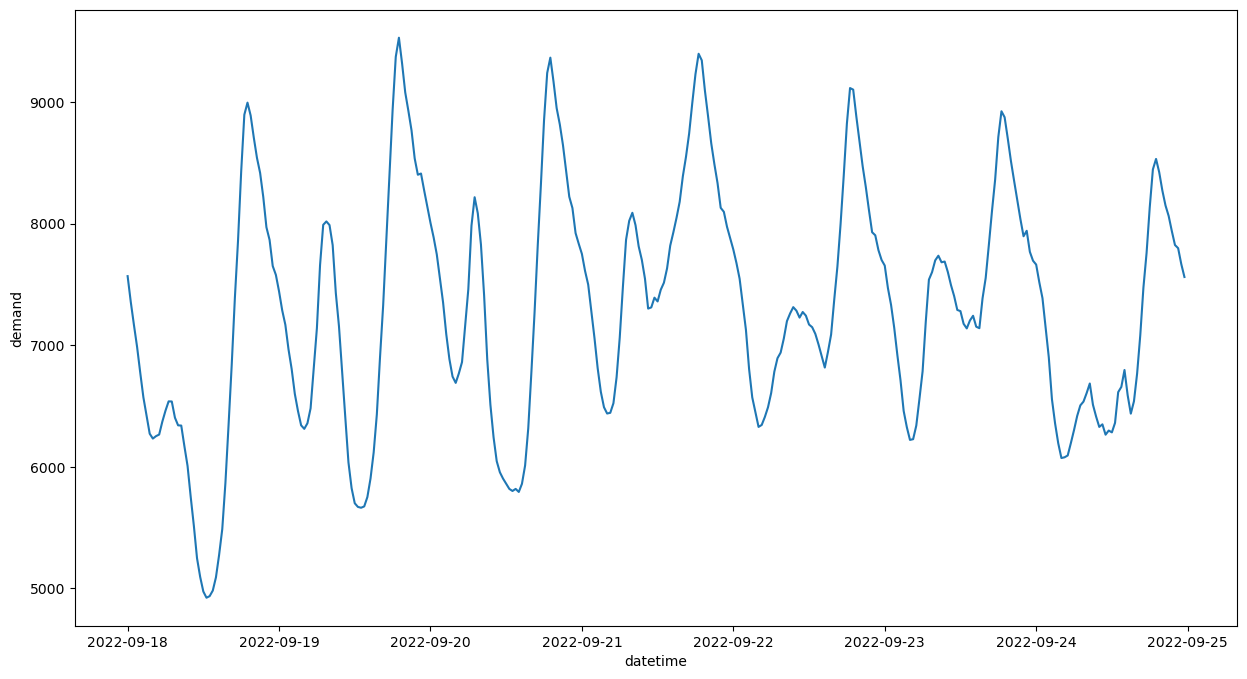

In [19]:
# Applying the same codes from above to create a line plot
plt.figure(figsize = (15, 8))
sns.lineplot(x = 'datetime', y = 'demand', data = df)

This is much much better, we can see the x-axis values as YYYY-MM-DD in better time intervals. 

> Ask yourself: 
> 1. What characteristics (trends, cycles, seasonality) do you notice in the time series above?
> 2. How do the characteristics change over time?

Given that <code>datetime</code> is in datetime, we can now manipulate our dataframe by:
1. Focussing on specific time periods of interest,
2. Summarizing and performing calculations over groups of time period.

## Task 3: Further transformations on time series data

Generally speaking, when we are provided with time series data, it is important to focus on specific time periods (for example, if you are provided with 10 years of financial data you would only need recent 1-2 years of data to perform meaningful forecasting), and to summarize data over time (for example, in the case of more detailed, semi-hourly <code>electricity</code> dataset, it may be more meaningful to report summary statistics at less detailed, daily level).

### Task 3.1. Focussing on specific time periods of interest

**Example 3.1.** How does the demand for electricity in NSW look like before 2022-09-18 05:00?

In [20]:
# Step 1: select time periods before a cut-off datetime into a new dataframe
df1 = df[df['datetime'] < pd.Timestamp('2022-09-18 05:00')]
df1

,region,datetime,demand
0,NSW1,2022-09-18 00:00:00,7568
5,NSW1,2022-09-18 00:30:00,7356
10,NSW1,2022-09-18 01:00:00,7167
15,NSW1,2022-09-18 01:30:00,6986
20,NSW1,2022-09-18 02:00:00,6774
25,NSW1,2022-09-18 02:30:00,6571
30,NSW1,2022-09-18 03:00:00,6420
35,NSW1,2022-09-18 03:30:00,6272
40,NSW1,2022-09-18 04:00:00,6232
45,NSW1,2022-09-18 04:30:00,6252


<Axes: xlabel='datetime', ylabel='demand'>

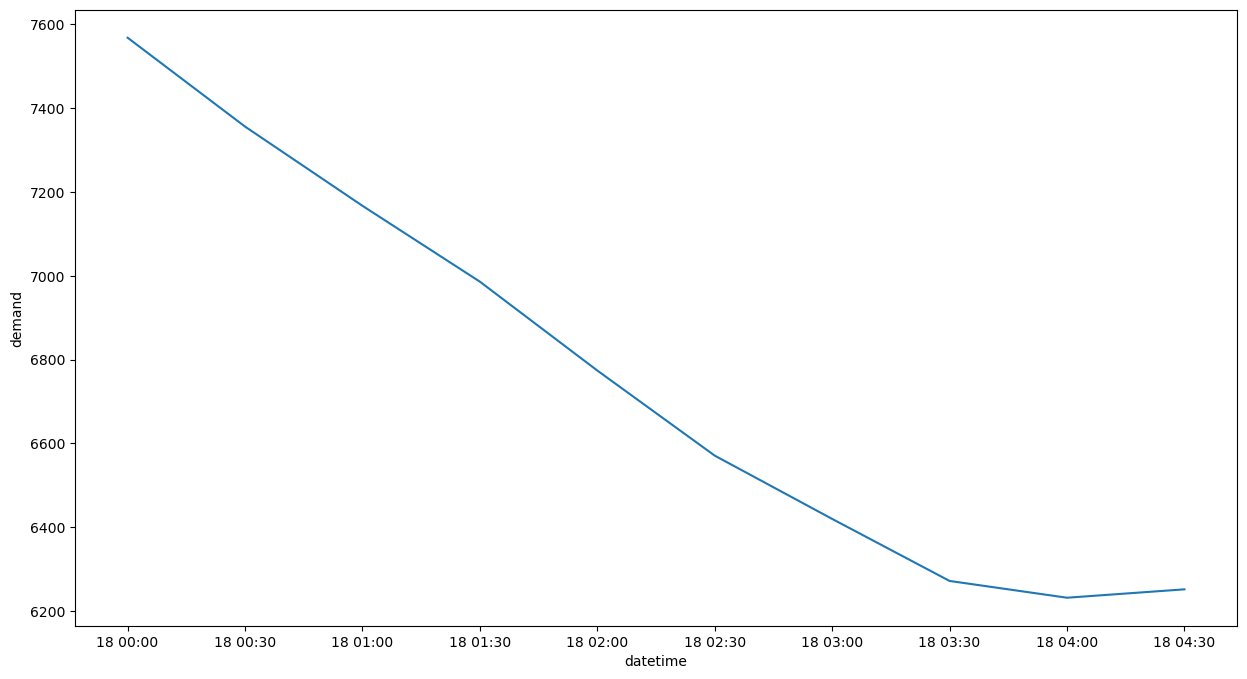

In [21]:
# Step 2: create line plot based on new dataframe
plt.figure(figsize = (15, 8))
sns.lineplot(x = 'datetime', y = 'demand', data = df1)

**Exercise 3.1.**  How does the demand for electricity in NSW look like after 2022-09-21 12:00?

<Axes: xlabel='datetime', ylabel='demand'>

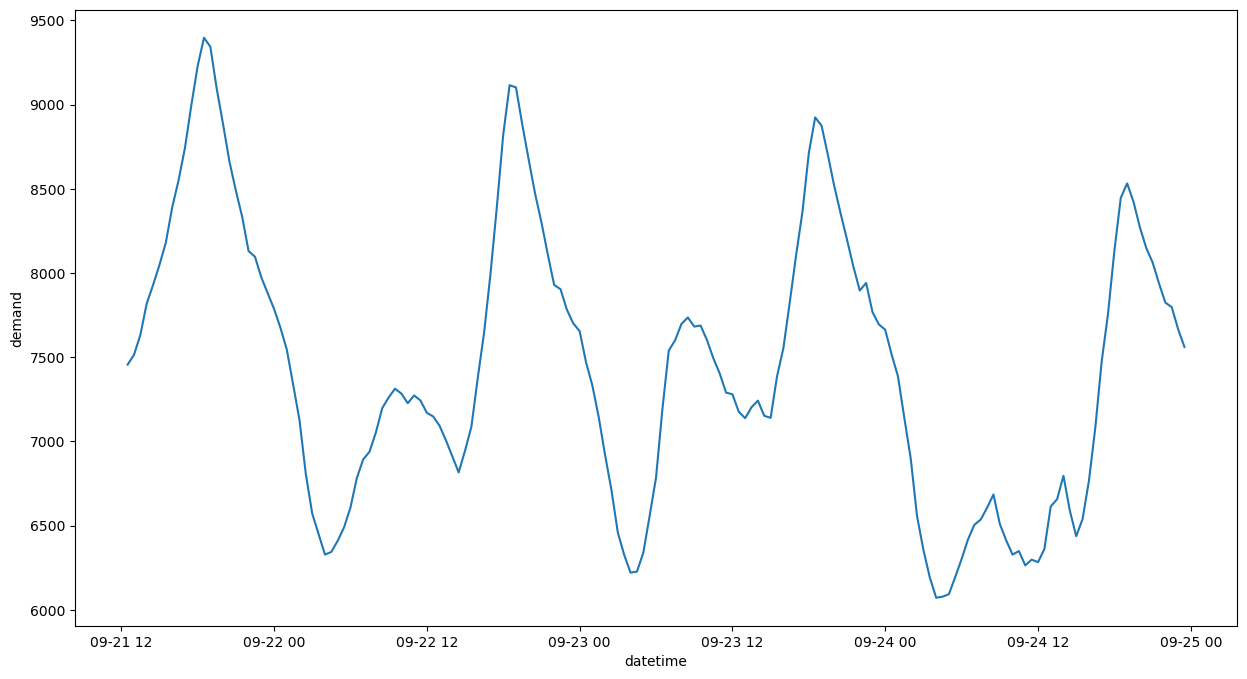

In [22]:
# Solutions for Exercise 3.1.
# Step 1: select time periods after a cut-off datetime into a new dataframe
df2 = df[df['datetime'] > pd.Timestamp('2022-09-21 12:00')]

# Step 2: create line plot based on new dataframe
plt.figure(figsize = (15, 8))
sns.lineplot(x = 'datetime', y = 'demand', data = df2)

### Task 3.2. Summarizing over groups of time period

In this task, we will be structuring the original dataframe differently to perform calculations over time within the same region. For more information about reshaping a dataframe: https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html. You may wish to refer to data munging functions from Lecture 2 too.

In [46]:
# Importing the data from scratch, reshaping the dataframe and applying datetime transformation
df = pd.read_csv('electricity.csv') 
df = df.pivot(columns='REGIONID', index='INTERVAL_DATETIME', values='OPERATIONAL_DEMAND').\
    reset_index().\
    rename_axis(None, axis=1).\
    rename(columns={'INTERVAL_DATETIME':'datetime', 'NSW1':'nsw', 'QLD1':'qld', 'SA1':'sa', 'TAS1':'tas', 'VIC1':'vic'})
df['datetime'] = pd.to_datetime(df["datetime"], infer_datetime_format=True)
df.head(10)

,datetime,nsw,qld,sa,tas,vic
0,2022-09-18 00:00:00,7568,5575,1578,1071,5349
1,2022-09-18 00:30:00,7356,5399,1551,1058,5172
2,2022-09-18 01:00:00,7167,5269,1551,1042,4968
3,2022-09-18 01:30:00,6986,5187,1503,1034,4831
4,2022-09-18 02:00:00,6774,5106,1462,1028,4623
5,2022-09-18 02:30:00,6571,5055,1386,1024,4475
6,2022-09-18 03:00:00,6420,5042,1329,1034,4381
7,2022-09-18 03:30:00,6272,5010,1294,1040,4296
8,2022-09-18 04:00:00,6232,5005,1265,1039,4255
9,2022-09-18 04:30:00,6252,5033,1235,1044,4241


In [33]:
# After reshaping the dataframe, the new dataframe has 336 rows (7 days x 48 observations per day) and 6 columns
df.shape

(336, 6)

In [34]:
# Check the shape and dtype of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  336 non-null    datetime64[ns]
 1   nsw       336 non-null    int64         
 2   qld       336 non-null    int64         
 3   sa        336 non-null    int64         
 4   tas       336 non-null    int64         
 5   vic       336 non-null    int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 15.9 KB


**Example 3.2.** For NSW and QLD, how does the hourly demand look like over time? Refer to: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.to_period.html and https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases

In [35]:
# Step 1. establish time period of interest i.e. hourly, daily, weekly etc using .to_period() and the appropriate offset alias
# note that 'datetime' variable is now period datatype, and is presented at hourly level
# this step is optional if you are sure of the offset alias to use
df["datetime"].dt.to_period('H')

0      2022-09-18 00:00
1      2022-09-18 00:00
2      2022-09-18 01:00
3      2022-09-18 01:00
4      2022-09-18 02:00
             ...       
331    2022-09-24 21:00
332    2022-09-24 22:00
333    2022-09-24 22:00
334    2022-09-24 23:00
335    2022-09-24 23:00
Name: datetime, Length: 336, dtype: period[H]

In [47]:
# Step 2. calculate hourly demand for selected regions using summary statistics across time period of interest
# note that it is necessary to convert 'datetime' from period datatype to string and finally datetime datatype for plotting
df3 = df[['nsw','qld']].groupby(df["datetime"].dt.to_period('H')).sum().reset_index()
df3['datetime'] = df3['datetime'].astype(str)
df3['datetime'] = pd.to_datetime(df3['datetime'], infer_datetime_format=True)
df3

,datetime,nsw,qld
0,2022-09-18 00:00:00,14924,10974
1,2022-09-18 01:00:00,14153,10456
2,2022-09-18 02:00:00,13345,10161
3,2022-09-18 03:00:00,12692,10052
4,2022-09-18 04:00:00,12484,10038
...,...,...,...
163,2022-09-24 19:00:00,16955,13213
164,2022-09-24 20:00:00,16421,12953
165,2022-09-24 21:00:00,16002,12500
166,2022-09-24 22:00:00,15622,11945


> Ask yourself:
> 1. What do you notice about the shape of this dataframe, compared to the dataframe in Task 1?
> 2. How would you ensure that the calculation is correct?

In [41]:
# Quick check to ensure all dtypes are correct
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  168 non-null    datetime64[ns]
 1   nsw       168 non-null    int64         
 2   qld       168 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.1 KB


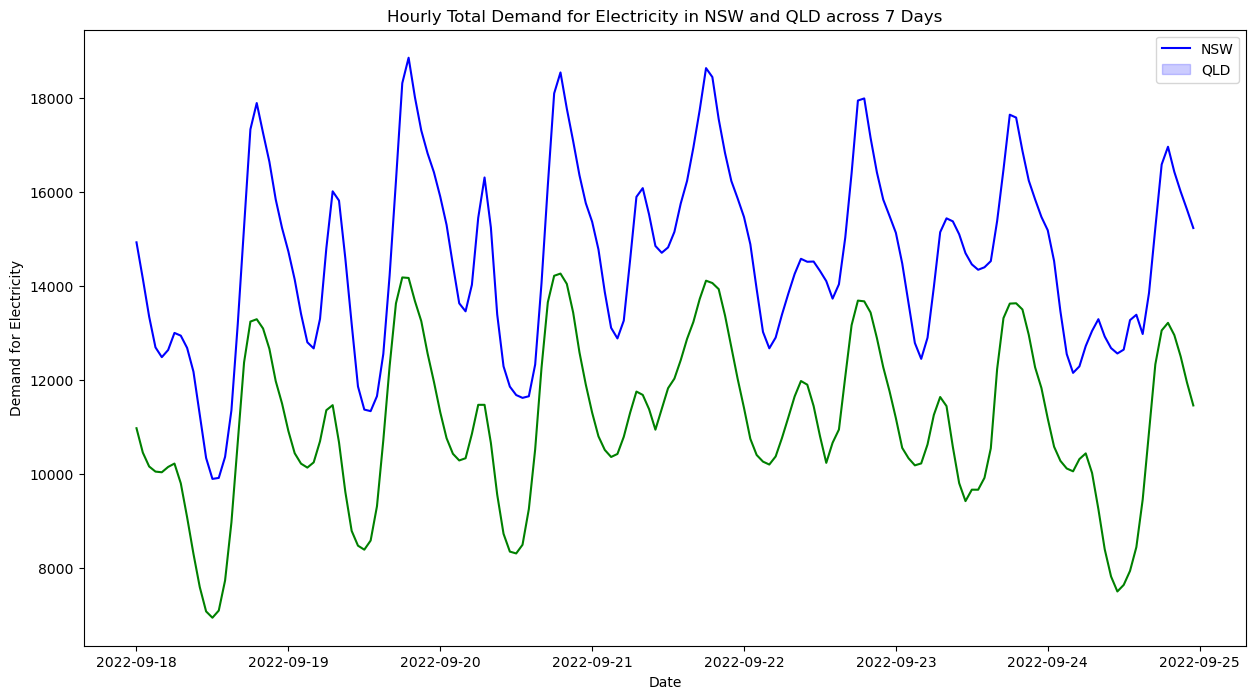

In [48]:
# Step 3. create line plot based on aggregated dataframe
# apply best practices in data visualization (setting meaningful axis labels, legends, and title)
plt.figure(figsize = (15, 8))
sns.lineplot(x = 'datetime', y = 'nsw', data = df3, color = 'b')
sns.lineplot(x = 'datetime', y = 'qld', data = df3, color = 'g')
plt.title('Hourly Total Demand for Electricity in NSW and QLD across 7 Days')
plt.xlabel('Date')
plt.ylabel('Demand for Electricity')
plt.legend(labels=['NSW','QLD'], facecolor='white')

> Ask yourself: What insights can you derive from this plot?

**Exercise 3.2.** How does the daily average demand for electricity look like between 2022-09-20 and 2022-09-24 (inclusive) for SA, TAS and VIC?

In [49]:
# Quick reference back to dataframe at the beginning of Task 3.2.
df.head()

,datetime,nsw,qld,sa,tas,vic
0,2022-09-18 00:00:00,7568,5575,1578,1071,5349
1,2022-09-18 00:30:00,7356,5399,1551,1058,5172
2,2022-09-18 01:00:00,7167,5269,1551,1042,4968
3,2022-09-18 01:30:00,6986,5187,1503,1034,4831
4,2022-09-18 02:00:00,6774,5106,1462,1028,4623


In [50]:
# Solutions for Exercise 3.2.
# Step 1: establish time period and region of interest
df4 = df[df['datetime']>='2022-09-20'][df['datetime']<'2022-09-25'][['datetime','sa', 'tas', 'vic']]
df4

,datetime,sa,tas,vic
96,2022-09-20 00:00:00,1567,1073,5421
97,2022-09-20 00:30:00,1549,1073,5186
98,2022-09-20 01:00:00,1559,1061,5015
99,2022-09-20 01:30:00,1525,1044,4878
100,2022-09-20 02:00:00,1463,1032,4733
...,...,...,...,...
331,2022-09-24 21:30:00,1624,1308,5450
332,2022-09-24 22:00:00,1594,1278,5326
333,2022-09-24 22:30:00,1553,1248,5220
334,2022-09-24 23:00:00,1478,1212,5083


In [59]:
# Step 2: calculate average demand for selected regions using summary statistics across time period of interest
# note that it is necessary to convert 'datetime' from period datatype to string and finally datetime datatype for plotting
df4 = df4.groupby(df4["datetime"].dt.to_period('D')).mean().reset_index(drop=True)
df4['datetime'] = df4['datetime'].astype(str)
df4['datetime'] = pd.to_datetime(df4['datetime'], infer_datetime_format=True)
df4

,datetime,sa,tas,vic
0,2022-09-20 11:45:00,1566.666667,1136.833333,4904.750000
1,2022-09-21 11:45:00,1469.916667,1062.145833,5124.020833
2,2022-09-22 11:45:00,1144.562500,954.520833,4213.375000
3,2022-09-23 11:45:00,1343.750000,1073.479167,4663.395833
4,2022-09-24 11:45:00,1072.916667,1227.000000,4248.520833


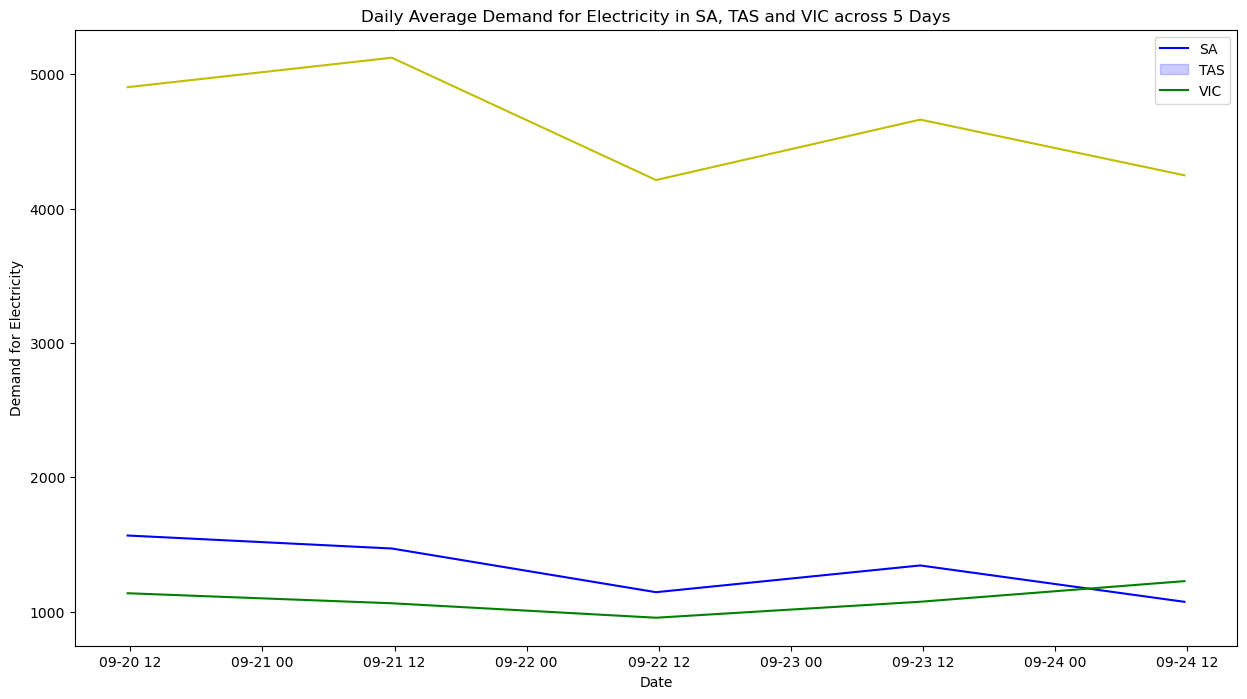

In [60]:
# Step 3. create a line plot based on aggregated dataframe
# apply best practices in data visualization (setting meaningful axis labels, legends, and title)
plt.figure(figsize = (15, 8))
sns.lineplot(x = 'datetime', y = 'sa', data = df4, color = 'b')
sns.lineplot(x = 'datetime', y = 'tas', data = df4, color = 'g')
sns.lineplot(x = 'datetime', y = 'vic', data = df4, color = 'y')
plt.title('Daily Average Demand for Electricity in SA, TAS and VIC across 5 Days')
plt.xlabel('Date')
plt.ylabel('Demand for Electricity')
plt.legend(labels=['SA','TAS', 'VIC'], facecolor='white')

> Ask yourself: What insights can you derive from this plot?